### _**Import Library**_

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import yfinance as yf
from IPython.display import display
from scipy.stats import norm
from matplotlib.lines import Line2D

print("Library berhasil diimpor!")

Library berhasil diimpor!


### **Persiapan Folder**

In [40]:
# Buat Folder untuk Hasil Output
output_folder = 'output'
os.makedirs(output_folder, exist_ok=True)
print(f"Folder '{output_folder}' sudah dibuat! Output gambar akan disimpan di folder '/{output_folder}'")

Folder 'output' sudah dibuat! Output gambar akan disimpan di folder '/output'


### **Download Data**

In [41]:
# Konfigurasi saham
KODE_SAHAM =  'BBCA.JK'
FILE_CSV = 'data.csv'

if not os.path.exists(FILE_CSV):
    print("File belum ada, mengunduh data dari Yahoo Finance...")
    
    df_download = yf.download(
        KODE_SAHAM, 
        period='5y', # Unduh data 5th terakhir
        auto_adjust=True # Koreksi harga kena Dividen/Split biar data bersih
        ) 
    df_download.to_csv(FILE_CSV)
    
    print(f"Download selesai! Data disimpan ke {FILE_CSV}.")
else:
    print(f"File {FILE_CSV} sudah ada.")

File data.csv sudah ada.


> **Keterangan Proses:**
> <br> Output di atas mengonfirmasi sumber data yang digunakan. Jika tercetak **"Download selesai"**, artinya data baru saja diperbarui dari bursa saham. Jika **"File sudah ada"**, simulasi menggunakan dataset yang tersimpan sebelumnya.

## **1. Data Loading & Initial Inspection**
Tahap ini memuat dataset historis dari file CSV. Melihat struktur data mentah (*raw data*) untuk mengidentifikasi baris metadata (header tambahan) yang perlu dibersihkan.

In [42]:
# Konfigurasi File
FILE_CSV = 'data.csv'

# Baca data
df = pd.read_csv(FILE_CSV)

display(df.head())
df.info()

,Price,Close,High,Low,Open,Volume
0,Ticker,BBCA.JK,BBCA.JK,BBCA.JK,BBCA.JK,BBCA.JK
1,Date,NaN,NaN,NaN,NaN,NaN
2,2020-12-14,6015.1455078125,6023.965369260905,5993.095854191486,5997.505784915689,179785500
3,2020-12-15,5988.6845703125,6085.703024323453,5825.517170384987,6023.964008134665,164024500
4,2020-12-16,6129.802734375,6129.802734375,6032.7842738309355,6050.423993929856,138674000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1208 entries, 0 to 1207
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Price   1208 non-null   object
 1   Close   1207 non-null   object
 2   High    1207 non-null   object
 3   Low     1207 non-null   object
 4   Open    1207 non-null   object
 5   Volume  1207 non-null   object
dtypes: object(6)
memory usage: 56.8+ KB


### **Analisis Struktur & Kualitas Data Mentah**

Berdasarkan tampilan sampel data (`head`) dan info teknis (`info`), terdapat 3 masalah struktural akibat format baru *yfinance*:

1.  **Metadata "Sampah":** Baris 0 dan 1 berisi informasi `Ticker` dan `NaN`, bukan data harga. Ini menyebabkan selisih jumlah baris (1208 vs 1207) pada `df.info()`.
2.  **Salah Label Kolom:** Kolom pertama bernama `Price`, padahal isinya adalah **Tanggal** (*Date*).
3.  **Tipe Data Invalid (Object):** Karena adanya teks di baris awal, Python membaca seluruh angka sebagai **Teks** (*Dtype: object*). Simulasi matematis tidak bisa dilakukan sebelum ini diperbaiki.

**Rencana Perbaikan (*Cleaning*):**
Tahap selanjutnya akan menghapus 2 baris teratas, memperbaiki nama kolom, dan konversi tipe data menjadi numerik.

## **2. Data Cleaning & Preprocessing**
Data mentah dari Yahoo Finance memiliki baris metadata (*Ticker* dan *Date*) yang tidak diperlukan. Tahap ini meliputi:
1. Menghapus 2 baris teratas (metadata).
2. Mereset indeks tabel.
3. Mengubah tipe data dari *Object* (Teks) menjadi *Float* (Angka) agar bisa dihitung secara statistik.

In [43]:
# Buat salinan data asli
df_clean = df.copy()

# 1. Hapus Baris Metadata (Ticker & Date)
if df_clean.iloc[0, 0] == 'Ticker':
    df_clean = df_clean.iloc[2:]
    print("(1) Berhasil menghapus 2 baris metadata (Ticker & Date)!")
    
# 2. Reset Index
df_clean = df_clean.reset_index(drop=True)

# 3a. Perbaiki Nama Kolom
if 'Price' in df_clean.columns:
    df_clean = df_clean.rename(columns={'Price': 'Date'})
    print("(2) Rename kolom 'Price' menjadi 'Date'!")
    
# 3b. Konversi Tipe Data kolom Date jdi datetime
if 'Date' in df_clean.columns:
    df_clean['Date'] = pd.to_datetime(df_clean['Date'])
    print("(3) Berhasil mengonversi kolom 'Date' menjadi tipe datetime!")
    
# 3c. Ubah Kolom Angka jadi Numerik
numeric_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
for col in numeric_cols:
    if col in df_clean.columns:
        df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')
        print(f"(4) Berhasil mengonversi kolom '{col}' menjadi tipe numerik!")
        
display(df_clean.head())
display(df_clean.describe())

data_harga = df_clean['Close']
print(f">> Data siap! Jumlah baris valid {len(data_harga)}.")

(1) Berhasil menghapus 2 baris metadata (Ticker & Date)!
(2) Rename kolom 'Price' menjadi 'Date'!
(3) Berhasil mengonversi kolom 'Date' menjadi tipe datetime!
(4) Berhasil mengonversi kolom 'Open' menjadi tipe numerik!
(4) Berhasil mengonversi kolom 'High' menjadi tipe numerik!
(4) Berhasil mengonversi kolom 'Low' menjadi tipe numerik!
(4) Berhasil mengonversi kolom 'Close' menjadi tipe numerik!
(4) Berhasil mengonversi kolom 'Volume' menjadi tipe numerik!


,Date,Close,High,Low,Open,Volume
0,2020-12-14,6015.145508,6023.965369,5993.095854,5997.505785,179785500
1,2020-12-15,5988.684570,6085.703024,5825.517170,6023.964008,164024500
2,2020-12-16,6129.802734,6129.802734,6032.784274,6050.423994,138674000
3,2020-12-17,6116.572754,6173.901842,6015.144366,6143.032333,91920000
4,2020-12-18,5997.504883,6116.572994,5957.815512,6116.572994,147238500


,Date,Close,High,Low,Open,Volume
count,1206,1206.000000,1206.000000,1206.000000,1206.000000,1.206000e+03
mean,2023-06-10 01:51:02.686567168,7867.843945,7939.005114,7801.477414,7870.182375,9.255806e+07
min,2020-12-14 00:00:00,5330.322754,5375.040446,5281.133534,5366.096478,1.065390e+07
25%,2022-03-08 06:00:00,6835.398682,6901.606975,6764.940832,6833.273505,5.822042e+07
50%,2023-06-06 12:00:00,8117.104492,8199.964844,8049.010249,8135.907950,7.739455e+07
75%,2024-09-09 18:00:00,8741.198242,8818.569568,8652.259279,8742.208983,1.064375e+08
max,2025-12-12 00:00:00,10500.997070,10500.997070,10333.171875,10453.046259,7.564316e+08
std,NaN,1288.344989,1295.697261,1281.143131,1286.983457,6.517613e+07


>> Data siap! Jumlah baris valid 1206.


### **Deskripsi Dataset (OHLCV)**

Data yang digunakan terdiri dari variabel standar pasar saham (*OHLCV*):
* **Date:** Tanggal transaksi perdagangan bursa (Hari kerja).
* **Open:** Harga pembukaan saham pada awal sesi perdagangan (pukul 09.00 WIB).
* **High:** Harga tertinggi yang dicapai saham pada hari tersebut.
* **Low:** Harga terendah yang dicapai saham pada hari tersebut.
* **Close:** Harga penutupan pada akhir sesi perdagangan (pukul 16.00 WIB). Variabel ini digunakan sebagai acuan utama dalam perhitungan *return* dan volatilitas.
* **Volume:** Jumlah lembar saham yang diperdagangkan. Menunjukkan likuiditas dan aktivitas pasar.

> **Pemilihan Data Harga**
> <br> Cuma ambil kolom **`Close`** (Harga Penutupan) sebagai data utama. 
> <br> Alasannya: Harga Close adalah nilai **final** yang disepakati pasar hari itu. Ini standar wajib analis saham buat ngitung untung/rugi, jadi simulasi bakal valid.

## **3. Analisis Statistik Data Historis**
Untuk membangun simulasi Monte Carlo yang valid, parameter model diestimasi berdasarkan properti *Geometric Brownian Motion* (GBM) menggunakan metode *Exact Simulation* sebagaimana dijelaskan oleh **Glasserman (2004)**.

1.  **Logarithmic Returns ($R_t$):**
    Berdasarkan definisi GBM, harga saham ($S_t$) memiliki sifat log-normal, yang berarti logaritma harganya ($\log S_t$) mengikuti gerak Brownian. Oleh karena itu, analisis menggunakan *log returns* sebagai data utama:
    $$R_t = \ln\left(\frac{S_t}{S_{t-1}}\right)$$
    *(Sumber: Glasserman, 2004, Hlm. 93, Section 3.2)*

2.  **Volatilitas ($\sigma$):**
    Diestimasi menggunakan **standar deviasi sampel** dari data *log returns*. Parameter ini merepresentasikan besaran fluktuasi atau risiko pasar.

3.  **Drift Parameter ($\nu$):**
    Dalam simulasi eksak (*exact simulation*), parameter tren yang digunakan adalah *drift* dari proses logaritma harga (bukan rata-rata perubahan harga secara aritmatika). Estimator terbaik dan tak bias (*unbiased estimator*) untuk parameter ini adalah **rata-rata sampel (*sample mean*)** dari data *log returns*.
    $$\text{Drift}_\text{simulasi} = \bar{R}$$
    *Catatan: Nilai ini sudah mencakup penyesuaian volatilitas ($\mu - \frac{1}{2}\sigma^2$) secara implisit karena dihitung dalam domain logaritma.*

*Referensi: Glasserman, P. (2004). Monte Carlo Methods in Financial Engineering. New York: Springer. (Halaman 93-94, Sub-bab 3.2 "Geometric Brownian Motion")*

Harga Terakhir (Start): Rp 8,000.00
Rata-rata Log Return (u): 0.000237
Volatilitas (stdev): 0.014536
Drift (Tren Murni): 0.000237
Gambar berhasil disimpan di: output\distribusi_log_return.png


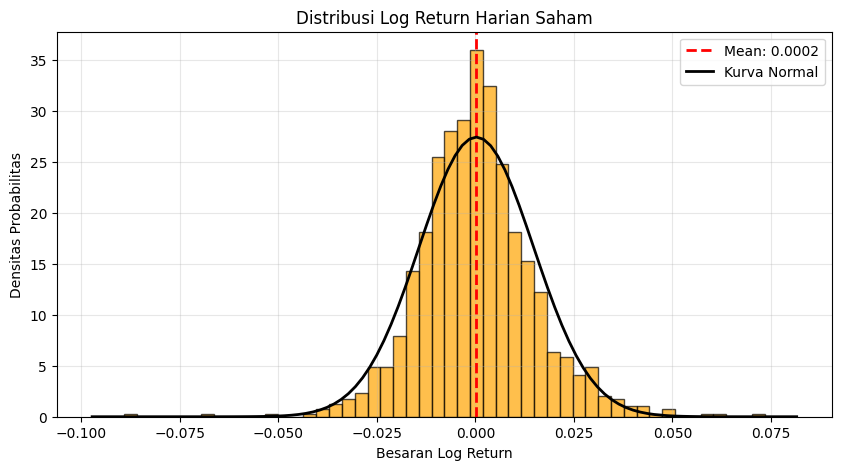

In [44]:
data_harga = df_clean['Close']

# 1. Hitung Return Harian (Log Returns)
log_returns = np.log(1 + data_harga.pct_change()).dropna() # Rumus: ln(Harga Hari Ini / Harga Kemarin)

# 2. Hitung Komponen Monte Carlo
u = log_returns.mean()      # Mean Log Return
var = log_returns.var()     # Variansi (Kuadrat dari volatilitas)
stdev = log_returns.std()   # Volatilitas (Standar Deviasi)

# 3. Drift 
drift = u

print(f"Harga Terakhir (Start): Rp {data_harga.iloc[-1]:,.2f}")
print(f"Rata-rata Log Return (u): {u:.6f}")
print(f"Volatilitas (stdev): {stdev:.6f}")
print(f"Drift (Tren Murni): {drift:.6f}")

# Histogrm
plt.figure(figsize=(10, 5))
plt.hist(log_returns, bins=50, color='orange', edgecolor='black', alpha=0.7, density=True)
plt.title(f"Distribusi Log Return Harian Saham")
plt.xlabel("Besaran Log Return")
plt.ylabel("Densitas Probabilitas")

# Garis Mean (Drift)
plt.axvline(u, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {u:.4f}')

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, u, stdev)
plt.plot(x, p, 'k', linewidth=2, label='Kurva Normal')

plt.legend()
plt.grid(True, alpha=0.3)

# Simpan Gambar
nama_file = os.path.join(output_folder, 'distribusi_log_return.png')
plt.savefig(nama_file, dpi=300, bbox_inches='tight')

print(f"Gambar berhasil disimpan di: {nama_file}")

plt.show()

#### **Intepretasi Histogram**

Grafik histogram di atas berfungsi untuk memverifikasi asumsi dasar metode *Geometric Brownian Motion* (GBM) menggunakan data *Log Return* saham BBCA.

1.  **Distribusi Normal (*Goodness of Fit*):**
    Terlihat bahwa pola data historis (batang oranye) membentuk kurva lonceng (*bell-shaped*) yang simetris dan berimpit presisi dengan garis kurva normal teoritis (garis hitam). Hal ini mengonfirmasi bahwa data *log return* saham BBCA **berdistribusi normal**, sesuai dengan syarat utama model GBM menurut Glasserman (2004).

2.  **Volatilitas:**
    Mayoritas data berkumpul tinggi di area tengah (sekitar angka 0), yang menunjukkan bahwa pergerakan harga harian cenderung stabil. Ekor grafik (*tails*) yang pendek menandakan bahwa fluktuasi ekstrem sangat jarang terjadi, mencerminkan karakteristik saham *Blue Chip* yang risikonya terukur.

3.  **Arah Tren (Drift):**
    Garis putus-putus merah (*Mean*) berada sedikit di sisi positif (kanan nol). Ini mengindikasikan bahwa meskipun ada fluktuasi harian, secara rata-rata jangka panjang saham ini memiliki tren pertumbuhan positif.

**Kesimpulan:**
Karena data *log return* terbukti berdistribusi normal, maka penggunaan metode simulasi Monte Carlo untuk memprediksi harga saham ini dinyatakan *valid dan memenuhi syarat statistik.*

## **4. Simulasi Monte Carlo (*Geometric Brownian Motion*)**

Simulasi dilakukan menggunakan metode **Exact Simulation** berdasarkan referensi **Glasserman (2004)**. Metode ini dipilih karena memberikan hasil yang paling akurat dan konsisten dengan sifat distribusi harga saham tanpa bias matematika.

Mengacu pada **Persamaan (3.22)**, rumus prediksi harga harian ($S_{t+1}$) disederhanakan menjadi:

$$S_{t+1} = S_t \times e^{(\text{Drift} \times \Delta t) + (\sigma \times \sqrt{\Delta t} \times Z)}$$

**Keterangan Parameter:**
* $S_t$: Harga saham hari sebelumnya.
* **Drift**: Tren rata-rata pergerakan harga. (Diestimasi langsung dari rata-rata *log-return*, $\bar{R}$).
* **$\sigma$ (Volatilitas)**: Tingkat fluktuasi harga (Standar deviasi *log-return*).
* **$Z$**: Angka acak (*Random Shock*) berdistribusi normal, $Z \sim N(0,1)$.
* **$\Delta t$**: Periode waktu (1 hari).

Pada setiap iterasi, nilai $Z$ akan berubah secara acak, menciptakan ribuan kemungkinan jalur harga di masa depan untuk analisis risiko.

*Referensi: Glasserman, P. (2004). Monte Carlo Methods in Financial Engineering. Hlm. 94, Persamaan 3.22.*

Memulai simulasi: 1000 skenario untuk 31 hari ke depan...
Simulasi Selesai!
Grafik berhasil disimpan di: output\spaghetti_plot.png


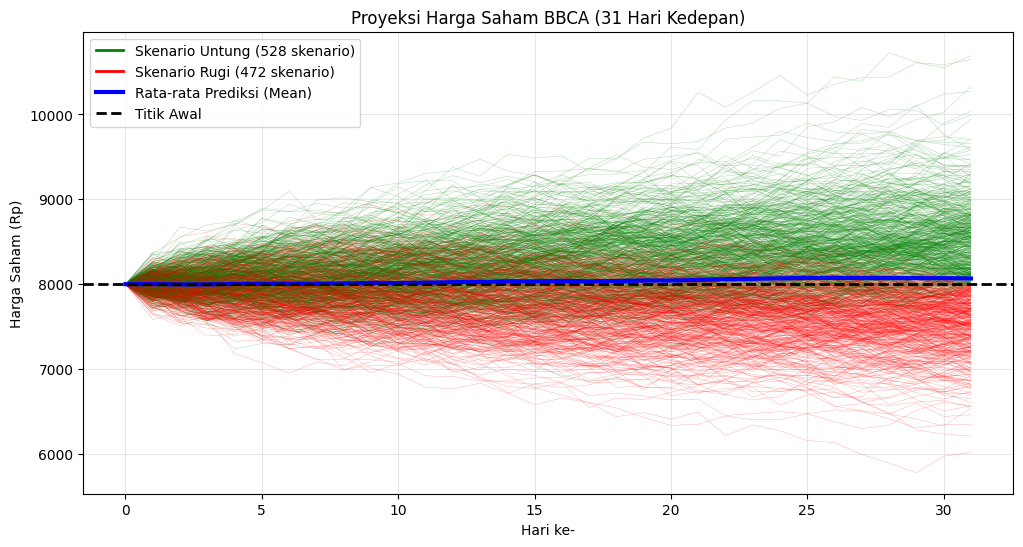


RINGKASAN PREDIKSI HARI KE-31
>> Skenario Terburuk (Min) : Rp 6,019
>> Ekspektasi Rata-rata    : Rp 8,067
>> Skenario Terbaik (Max)  : Rp 10,694


In [ ]:
# Param Simulasi
hari_prediksi = 31   # 31 hari (sesuai in jumlah hari bulan Januari)
jml_simulasi = 1000  # Jumlah skenario
dt = 1               # Time step (harian)

# Harga terakhir sbg titik awal (S0)
S0 = data_harga.iloc[-1]

simulasi_harga = np.zeros((hari_prediksi + 1, jml_simulasi)) # wadah array 32 krn Hari ke-0 + 31 Hari Prediksi
simulasi_harga[0] = S0 

print(f"Memulai simulasi: {jml_simulasi} skenario untuk {hari_prediksi} hari ke depan...")

# Proses Iterasi
np.random.seed(12) # hasilnya biar konsisten tiap dirun

for t in range(1, hari_prediksi + 1):
    Z = np.random.normal(0, 1, jml_simulasi)
    
    # Rumus Eksak GBM (Glasserman, Eq 3.22):
    simulasi_harga[t] = simulasi_harga[t-1] * np.exp(drift + (stdev * Z))
    # Note: Karena ini simulasinya harian, maka delta_t = 1.
    # Sehingga, (drift * 1) tetap 'drift', dan (stdev * sqrt(1)) tetap 'stdev'.

print("Simulasi Selesai!")

# Visualisasi Spaghetti Plot
plt.figure(figsize=(12, 6))

for i in range(1000):
    harga_akhir_skenario = simulasi_harga[-1, i]
    
    if harga_akhir_skenario > S0:
        warna = 'green'   # Cuan
    else:
        warna = 'red'     # Boncos
        
    plt.plot(simulasi_harga[:, i], color=warna, alpha=0.5, linewidth=0.2)

legend_elements = [
    Line2D([0], [0], color='green', lw=2, label=f'Skenario Untung ({np.sum(simulasi_harga[-1] > S0)} skenario)'),
    Line2D([0], [0], color='red', lw=2, label=f'Skenario Rugi ({np.sum(simulasi_harga[-1] <= S0)} skenario)'),
    Line2D([0], [0], color='blue', lw=3, label='Rata-rata Prediksi (Mean)'),
    Line2D([0], [0], color='black', lw=2, linestyle='--', label='Titik Awal')
]

# Garis Rata-rata
rata_rata_simulasi = simulasi_harga.mean(axis=1)
plt.plot(rata_rata_simulasi, color='blue', linewidth=3)

plt.axhline(y=S0, color='black', linestyle='--', linewidth=2) # Garis Start

plt.title(f"Proyeksi Harga Saham BBCA ({hari_prediksi} Hari Kedepan)")
plt.xlabel("Hari ke-")
plt.ylabel("Harga Saham (Rp)")
plt.legend(handles=legend_elements, loc='upper left')
plt.grid(True, alpha=0.3)

# Simpan Gambar
nama_file = os.path.join(output_folder, 'spaghetti_plot.png')
plt.savefig(nama_file, dpi=300, bbox_inches='tight')
print(f"Grafik berhasil disimpan di: {nama_file}")

plt.show()

# Ringkasan Hasil Simulasi
harga_akhir = simulasi_harga[-1]

print(f"\nRINGKASAN PREDIKSI HARI KE-{hari_prediksi}")
print(f">> Skenario Terburuk (Min) : Rp {np.min(harga_akhir):,.0f}")
print(f">> Ekspektasi Rata-rata    : Rp {np.mean(harga_akhir):,.0f}")
print(f">> Skenario Terbaik (Max)  : Rp {np.max(harga_akhir):,.0f}")

#### **Intepretasi Hasil Simulasi**

Grafik ini memvisualisasikan **1.000 skenario** pergerakan harga BBCA untuk **31 hari ke depan (Januari).**

1.  **Tren Rata-rata (Garis Biru):** 
    Garis tebal biru bergerak menanjak. Ini menunjukkan bahwa secara statistik, ekspektasi harga rata-rata di masa depan adalah naik (positif).

2.  **Probabilitas Keuntungan (Dominasi Hijau):** 
    Visualisasi garis hijau jauh lebih padat dibandingkan garis merah. Artinya, peluang investor mendapatkan **keuntungan (*capital gain*)** lebih besar daripada risiko kerugian.

3.  **Risiko Ketidakpastian (Bentuk Corong):** 
    Rentang harga melebar seiring bertambahnya hari. Ini wajar, menandakan bahwa semakin jauh prediksi waktu, semakin tinggi tingkat ketidakpastian (volatilitas) pasar.

**Kesimpulan:** Berdasarkan simulasi, saham BBCA memiliki **prospek pertumbuhan yang kuat** untuk bulan Januari dengan rasio Risk-Reward yang menarik (lebih besar potensi untung).

## **5. Analisis Probabilitas & Kesimpulan Akhir**

Setelah menjalankan simulasi, langkah terakhir adalah menganalisis distribusi harga pada akhir periode (Hari ke-31) dari seluruh 1.000 skenario.

Analisis ini menggunakan **Confidence Interval 90%** untuk menentukan rentang prediksi yang realistis dan memitigasi risiko outlier:
* **Batas Bawah (Persentil 5):** Level *support* psikologis (Skenario Pesimistis).
* **Batas Atas (Persentil 95):** Level *resistance* potensial (Skenario Optimistis).
* **Mean (Rata-rata):** Target harga moderat yang diharapkan (*Expected Value*).

Pendekatan ini memberikan gambaran risiko dan potensi keuntungan yang lebih terukur bagi investor dibandingkan hanya melihat satu angka prediksi.

Grafik Histogram berhasil disimpan di: output\histogram_distribusi_akhir.png


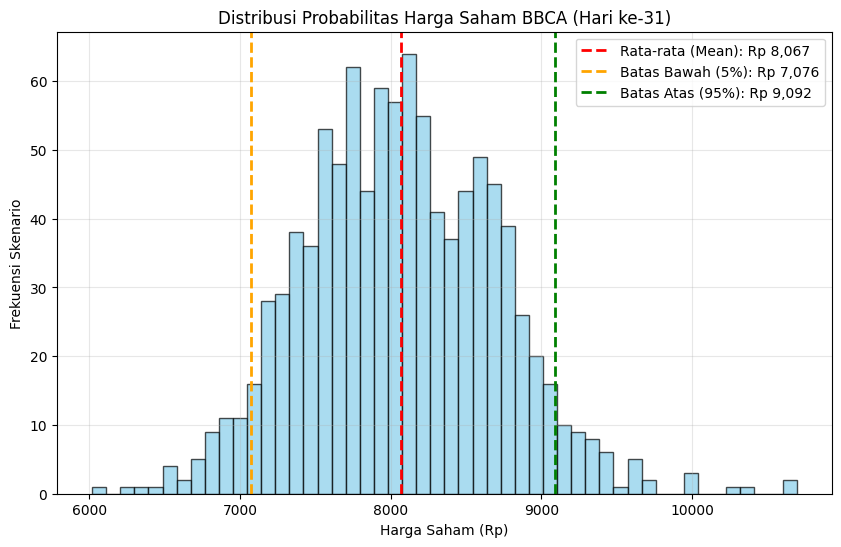


KESIMPULAN PREDIKSI (Confidence Level 90%)
> Skenario Pesimistis (Support Kuat) : Rp 7,076
> Target Harga Wajar (Mean)          : Rp 8,067
> Skenario Optimistis (Resistance)   : Rp 9,092


In [63]:
# Data harga pada hari terakhir dari 1000 skenario
harga_akhir = simulasi_harga[-1]

# Statistik Deskriptif (CI 90%)
mean_akhir = np.mean(harga_akhir)
q5 = np.percentile(harga_akhir, 5)   # Batas Bawah (Skenario Pesimistis)
q95 = np.percentile(harga_akhir, 95) # Batas Atas (Skenario Optimistis)

# Histogram
plt.figure(figsize=(10, 6))
plt.hist(harga_akhir, bins=50, color='skyblue', edgecolor='black', alpha=0.7)

plt.axvline(mean_akhir, color='red', linestyle='dashed', linewidth=2, label=f'Rata-rata (Mean): Rp {mean_akhir:,.0f}')
plt.axvline(q5, color='orange', linestyle='--', linewidth=2, label=f'Batas Bawah (5%): Rp {q5:,.0f}')
plt.axvline(q95, color='green', linestyle='--', linewidth=2, label=f'Batas Atas (95%): Rp {q95:,.0f}')

plt.title(f"Distribusi Probabilitas Harga Saham BBCA (Hari ke-{hari_prediksi})")
plt.xlabel("Harga Saham (Rp)")
plt.ylabel("Frekuensi Skenario")
plt.legend()
plt.grid(True, alpha=0.3)

# Simpan Gambar
nama_file = os.path.join(output_folder, 'histogram_distribusi_akhir.png')
plt.savefig(nama_file, dpi=300, bbox_inches='tight')
print(f"Grafik Histogram berhasil disimpan di: {nama_file}")

plt.show()

# Kesimpulan 
print("\n" + "="*55)
print(f"KESIMPULAN PREDIKSI (Confidence Level 90%)")
print("="*55)
print(f"> Skenario Pesimistis (Support Kuat) : Rp {q5:,.0f}")
print(f"> Target Harga Wajar (Mean)          : Rp {mean_akhir:,.0f}")
print(f"> Skenario Optimistis (Resistance)   : Rp {q95:,.0f}")
print("="*55)

### **Interpretasi Hasil**

Grafik histogram di atas merangkum 1.000 kemungkinan harga saham di akhir bulan Januari (Hari ke-31).

1.  **Mayoritas di Tengah:**
    Bentuk grafik yang tinggi di tengah (seperti lonceng) menunjukkan bahwa sebagian besar skenario berakhir di harga rata-rata. Kejadian ekstrem (harga jatuh parah atau naik tidak wajar) sangat jarang terjadi.

2.  **Batasan Harga Wajar (90% Akurat):**
    * **Garis Oranye (Support):** **Batas Aman Terbawah.** Kemungkinan harga jatuh di bawah garis ini sangat kecil (hanya 5%).
    * **Garis Hijau (Resistance):** **Target Tertinggi.** Ini adalah harga tertinggi yang masih masuk akal untuk dicapai dalam sebulan ke depan.
    * **Garis Merah (Mean):** **Harga Paling Mungkin.** Ini adalah angka rata-rata yang menjadi target utama pergerakan harga.

**Kesimpulan:**
Harga saham BBCA diprediksi kuat akan bergerak di dalam area kurva biru dan berakhir di sekitar garis merah (Rata-rata).

## **6. Perhitungan Value at Risk (VaR)**

Setelah mendapatkan distribusi harga masa depan melalui simulasi Monte Carlo, langkah selanjutnya adalah menghitung risiko kerugian maksimum menggunakan metode **Monte Carlo VaR**.

**Value at Risk (VaR)** mengestimasi potensi kerugian terbesar yang mungkin terjadi dalam periode waktu tertentu (31 hari) dengan tingkat kepercayaan tertentu (95%).

Rumus perhitungan Monte Carlo VaR:
$$VaR_{\alpha} = S_0 - S_{percentile(1-\alpha)}$$

Dimana:
* $S_0$: Harga saham awal (saat ini).
* $\alpha$: Tingkat kepercayaan (misal 95%, maka kita ambil persentil ke-5).
* $S_{percentile}$: Harga saham pada batas bawah distribusi simulasi.

In [64]:
# Asumsi Investasi
modal_awal = S0  # Harga saham saat ini (per lembar)

# 1. Tentukan Tingkat Kepercayaan (Confidence Level)
# Biasanya 95% (artinya kita melihat risiko di 5% kejadian terburuk)
confidence_level = 0.95
alpha = 1 - confidence_level # 5% atau 0.05

# 2. Ambil Harga pada Persentil ke-5 (Skenario Buruk)
# Ini sudah kita hitung sebelumnya sebagai 'q5', tapi kita hitung ulang biar jelas
harga_terburuk = np.percentile(harga_akhir, alpha * 100)

# 3. Hitung VaR (Selisih Modal Awal dikurangi Harga Terburuk)
# VaR = Uang yang mungkin hilang
VaR_nominal = modal_awal - harga_terburuk
VaR_persen = (VaR_nominal / modal_awal) * 100

# --- TAMPILKAN HASIL ---
print("\n" + "="*50)
print(f"ANALISIS RISIKO: VALUE AT RISK (VaR {confidence_level*100:.0f}%)")
print("="*50)
print(f"Harga Saham Saat Ini (S0) : Rp {modal_awal:,.0f}")
print(f"Prediksi Terburuk (5%)    : Rp {harga_terburuk:,.0f}")
print("-" * 50)
print(f"⚠️ POTENSI KERUGIAN MAKS (VaR):")
print(f">> Nominal : Rp {VaR_nominal:,.2f} per lembar")
print(f">> Persen  : -{VaR_persen:.2f}%")
print("="*50)

# Simulasi kalau beli 100 Lot (1 Lot = 100 lembar)
investasi_lot = 100
total_lembar = investasi_lot * 100
total_uang = total_lembar * modal_awal
total_risiko = total_lembar * VaR_nominal

print(f"\n[Simulasi Real]")
print(f"Jika Anda membeli {investasi_lot} Lot BBCA hari ini (Modal: Rp {total_uang:,.0f}),")
print(f"maka risiko kerugian maksimal Anda bulan depan adalah: Rp {total_risiko:,.0f}")


ANALISIS RISIKO: VALUE AT RISK (VaR 95%)
Harga Saham Saat Ini (S0) : Rp 8,000
Prediksi Terburuk (5%)    : Rp 7,076
--------------------------------------------------
⚠️ POTENSI KERUGIAN MAKS (VaR):
>> Nominal : Rp 924.24 per lembar
>> Persen  : -11.55%

[Simulasi Real]
Jika Anda membeli 100 Lot BBCA hari ini (Modal: Rp 80,000,000),
maka risiko kerugian maksimal Anda bulan depan adalah: Rp 9,242,385
